## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

### 1. First, we compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)

cv2.destroyAllWindows()

In [3]:
import matplotlib.image as mpimg

In [4]:
img = mpimg.imread('./camera_cal/calibration5.jpg')
image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[::-1],None,None)

def undistort(img, mtx = mtx, dist = dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

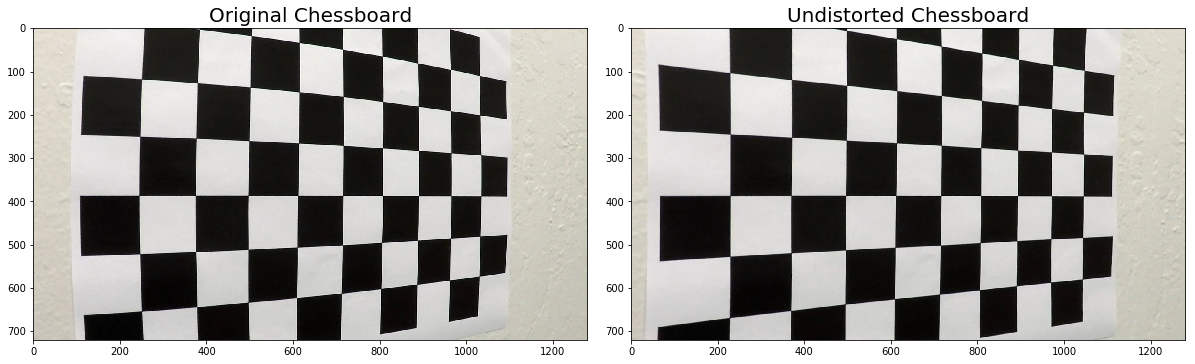

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Chessboard', fontsize=20)
ax2.imshow(undistort(img)) # Using undistort() function as defined above
ax2.set_title('Undistorted Chessboard', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
#plt.savefig('./carnd-advanced-lanes/outputs/calibration.jpg')

#### Testing our undistort function with sample images

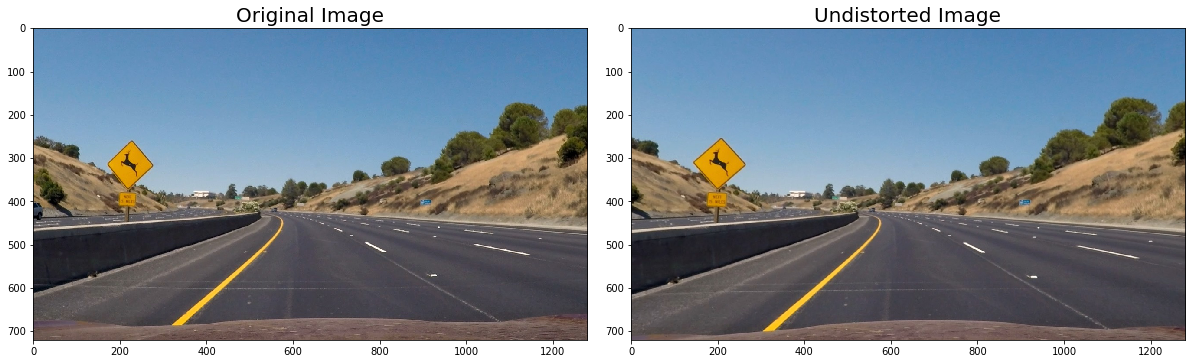

In [10]:
img = mpimg.imread('./test_images/test2.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistort(img)) # Using undistort() function as defined above
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
#plt.savefig('undistortion.jpg')

### 2. Extracting lane line data
Final pipeline: take thresholded x-gradient of the saturation channel, and combined it with the thresholded saturation channel.

In [11]:
# This is not the final pipeline, it just uses color and gradient thresholds.
def pipeline(img):
    # Converting to HLS space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Extracting Saturation channel
    v_channel = hls[:,:,2]
    # Extracting red color channel
    red = img[:,:,0].astype(np.float)
    zero = np.zeros_like(gray)
    
    # Gradient thresholding
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= 20) & (scaled_sobel <= 80)] = 1
    
    # Saturation thresholding
    s_binary = np.zeros_like(v_channel)
    s_binary[(v_channel >= 170) & (v_channel <= 255)] = 1
    
    # Combine both thresholded binary images
    combined = np.zeros_like(red)
    combined[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined # 2-D image, single channel


#### Testing thresholding pipeline on test images

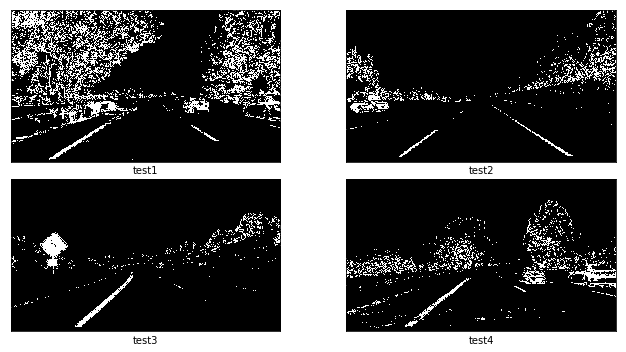

In [12]:
img1 = undistort(mpimg.imread('./test_images/test5.jpg'))
img2 = undistort(mpimg.imread('./test_images/straight_lines2.jpg'))
img3 = undistort(mpimg.imread('./test_images/test2.jpg'))
img4 = undistort(mpimg.imread('./test_images/test4.jpg'))

fig = plt.figure(figsize=(10,5))
axes = []

axis = fig.add_subplot(2,2,1)
axis.set_xlabel('test1')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(pipeline(img1), cmap='gray')

axis = fig.add_subplot(2,2,2)
axis.set_xlabel('test2')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(pipeline(img2), cmap='gray')

axis = fig.add_subplot(2,2,3)
axis.set_xlabel('test3')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(pipeline(img3), cmap='gray')

axis = fig.add_subplot(2,2,4)
axis.set_xlabel('test4')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(pipeline(img4), cmap='gray')

plt.tight_layout(h_pad=0, w_pad=0)
#plt.savefig('./outputs/thresholding.jpg')
plt.show()

### 3. Warping the image

In [13]:
def warp(image):
    src = np.float32([[544, 470], [736, 470],
                  [128, 700], [1152, 700]])

    dist = np.float32([[256, 128], [1024, 128],
                  [256, 720], [1024, 720]])
    
    img_size = (img2.shape[1], img2.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dist)

    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)


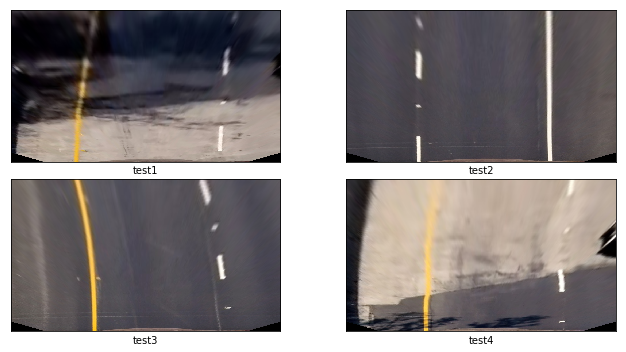

In [14]:
fig = plt.figure(figsize=(10,5))
axes = []

axis = fig.add_subplot(2,2,1)
axis.set_xlabel('test1')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(warp(img1))

axis = fig.add_subplot(2,2,2)
axis.set_xlabel('test2')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(warp(img2))

axis = fig.add_subplot(2,2,3)
axis.set_xlabel('test3')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(warp(img3))

axis = fig.add_subplot(2,2,4)
axis.set_xlabel('test4')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(warp(img4))

plt.tight_layout(h_pad=0, w_pad=0)
plt.show()
#plt.savefig('./carnd-advanced-lanes/outputs/warps.jpg')

### 4. Finding region of interest
ROI includes only road lanes

In [15]:
def region_of_interest(img, vertices= np.array([[[564, 430], [716, 430], [1152, 700], [128, 700]]])):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

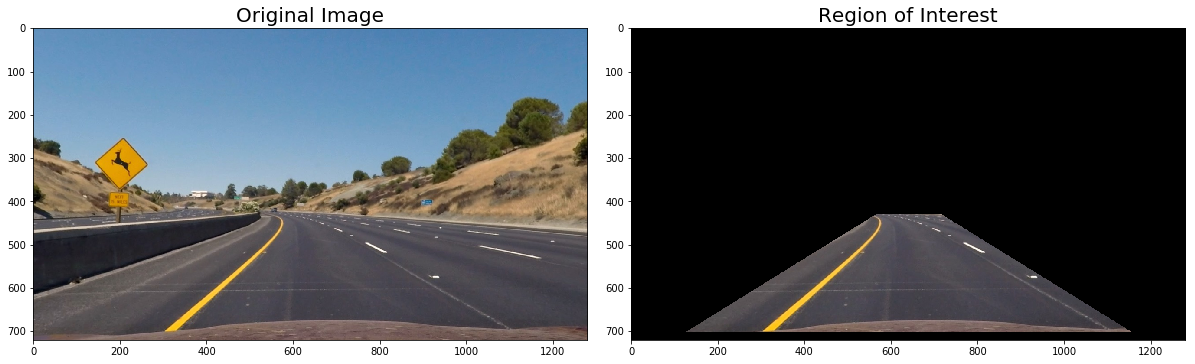

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(img3)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(region_of_interest(img3)) # Using undistort() function as defined above
ax2.set_title('Region of Interest', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
#plt.savefig('./outputs/roi.jpg')

##### Undistort + Lane Extraction + Region of Interest + Perspective Transform

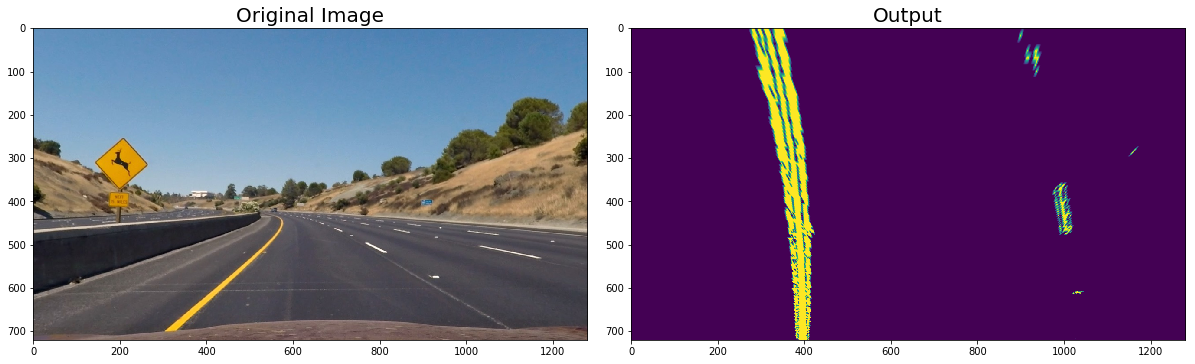

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(img3)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warp(pipeline(region_of_interest(img3)))) # Using undistort() function as defined above
ax2.set_title('Output', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
#plt.savefig('./outputs/warped_lanes.jpg')

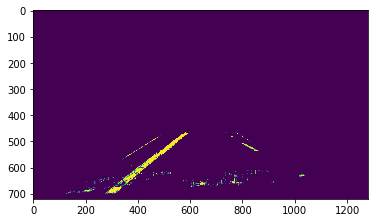

In [20]:
# Testing the function for reverse-warp, to be used later
src = np.float32([[544, 470], [736, 470], [128, 700], [1152, 700]])

dist = np.float32([[256, 128], [1024, 128], [256, 720], [1024, 720]])
Minv = cv2.getPerspectiveTransform(dist, src)
newwarp = cv2.warpPerspective(warp(pipeline(region_of_interest(img4))), Minv, (image.shape[1], image.shape[0])) 
plt.imshow(newwarp)
plt.show()

### Finding lanes (PRACTICE CODE)

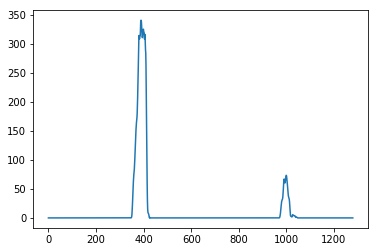

In [21]:
warped = warp(pipeline(region_of_interest(img3)))
histogram = np.sum(warped[360:,:], axis=0)
plt.plot(histogram)
left_base, right_base = np.argmax(histogram[:640]), 640 + np.argmax(histogram[640:])
plt.show()
#plt.savefig('histogram.jpg')

[ -1.70432405e-04   2.34057720e-01   3.15197455e+02]


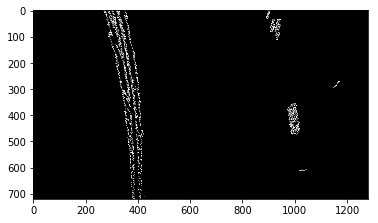

In [271]:
#Current position of left and right lanes
leftx_current, rightx_current = left_base, right_base

# Empty lists to keep individual pixel indices
left_lane_inds, right_lane_inds = [], []

nwindows = 10
binary = warp(pipeline(region_of_interest(img3)))
window_height = binary.shape[0] / nwindows

nonzero = binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

margin = 50
minpix = 50

out_img = np.dstack((binary, binary, binary))*255
plt.imshow(out_img)

for window in range(nwindows):
    win_y_low = int(binary.shape[0] - (window+1)*window_height)
    win_y_high = int(binary.shape[0] - window*window_height)
    win_xleft_low = int(leftx_current - margin)
    win_xleft_high = int(leftx_current + margin)
    win_xright_low = int(rightx_current - margin)
    win_xright_high = int(rightx_current + margin)
    # Draw the windows on the visualization image
    # cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,0), 3)
    # cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,0,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print (left_fit)

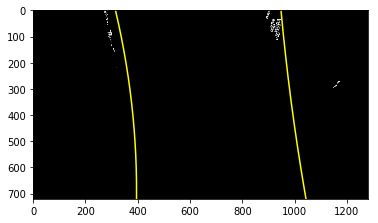

In [277]:
ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Just for visualization of polynomial
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#plt.savefig('./outputs/lines.jpg')

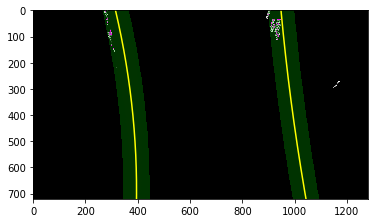

In [278]:
out_img = np.dstack((binary, binary, binary))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#plt.savefig('./outputs/search_area.jpg')

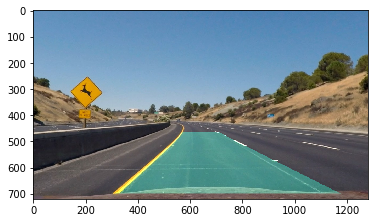

In [279]:
Minv = cv2.getPerspectiveTransform(dist, src)
#warped = warp(pipeline(region_of_interest(img3)))

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 200))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img3, 1, newwarp, 0.3, 0)
plt.imshow(result)
#plt.savefig('./outputs/lanes.jpg')

### Final Pipeline for Processing Images

In [24]:
from datetime import datetime

global left_fit_previous
global right_fit_previous    
left_fit_previous = []
right_fit_previous = []

def process_image(image):
    warped = warp(pipeline(region_of_interest(undistort(image))))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    
    # Global variables to store previous frame's line equations
    global left_fit_previous
    global right_fit_previous
    
    # If we already have existing lane lines
    # Instead of searching with a blank slate, let's use the previous curves for efficiency and smoothness
    if ((len(left_fit_previous) == 3) & (len(right_fit_previous) == 3)):
        
        # Getting all non-zero coordinates from warped image
        # Splitting them into x- and y-
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        margin = 50
        minpix = 50
        
        # Directly use the line equation to create boundaries for finding lane pixels
        left_lane_inds = ((nonzerox > (left_fit_previous[0]*(nonzeroy**2) 
                                       + left_fit_previous[1]*nonzeroy 
                                       + left_fit_previous[2] - margin))
                        & (nonzerox < (left_fit_previous[0]*(nonzeroy**2) 
                                         + left_fit_previous[1]*nonzeroy 
                                         + left_fit_previous[2] + margin))) 
        
        right_lane_inds = ((nonzerox > (right_fit_previous[0]*(nonzeroy**2) 
                                        + right_fit_previous[1]*nonzeroy 
                                        + right_fit_previous[2] - margin)) 
                        & (nonzerox < (right_fit_previous[0]*(nonzeroy**2) 
                                       + right_fit_previous[1]*nonzeroy 
                                       + right_fit_previous[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Adding a debugging statement which catches any annoying frames and saves them for reference. :)
        if ((rightx.size == 0) | (leftx.size == 0)):
            time = (str(datetime.now())[11:-7])
            filename = 'bugger_' + time + '.jpg'
            cv2.imwrite(filename, image)

        # Fit a new second order polynomial to each lane
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Updating the previous line equations for next frame
        left_fit_previous = left_fit
        right_fit_previous = right_fit
        
        # Generate x and y values for plotting, based on line equations
        # Ploty is a sequence of y coordinates generated just for this purpose
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    else:
        # If there are no previous lines and we have to search for equations from a blank slate

        # Draw up a histogram of the pixel values, to detect lanes
        histogram = np.sum(warped[360:,:], axis=0)
        # Use argmax() to get x-coordinate of lanes
        left_base, right_base = np.argmax(histogram[:640]), 640 + np.argmax(histogram[640:])

        #Current position of left and right lanes
        leftx_current, rightx_current = left_base, right_base

        # Empty lists to keep individual pixel indices
        left_lane_inds, right_lane_inds = [], []

        #splitting the frame into windows
        nwindows = 10
        window_height = warped.shape[0] / nwindows

        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        margin = 50
        minpix = 50
        
        for window in range(nwindows):
            
            # Defining 'boxes' in which we will search for lane points, based on current lane position.
            # Upper and lower limit of box
            win_y_low = int(warped.shape[0] - (window+1)*window_height)
            win_y_high = int(warped.shape[0] - window*window_height)
            # Left and right edges of the Left-Lane box
            win_xleft_low = int(leftx_current - margin)
            win_xleft_high = int(leftx_current + margin)
            # Left and right edges of the Right-Lane box
            win_xright_low = int(rightx_current - margin)
            win_xright_high = int(rightx_current + margin)
            
            # Identify the nonzero pixels in x and y within the boxes of that window
            good_left_inds = ((nonzeroy >= win_y_low) 
                              & (nonzeroy < win_y_high) 
                              & (nonzerox >= win_xleft_low) 
                              & (nonzerox < win_xleft_high)).nonzero()[0]
            
            good_right_inds = ((nonzeroy >= win_y_low) 
                               & (nonzeroy < win_y_high) 
                               & (nonzerox >= win_xright_low) 
                               & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels in a window, use that box's center as the center for next window
            if ((len(good_left_inds) > minpix) & (len(good_right_inds) > minpix)):
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract all pixel coordinates for left and right lanes
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Adding a debugging statement which catches any annoying frames and saves them for reference. :)
        if ((rightx.size == 0) | (leftx.size == 0)):
            time = (str(datetime.now())[11:-7])
            filename = 'bugger_' + time + '.jpg'
            cv2.imwrite(filename, image)

        # Fit a second order polynomial to each
        # np.polyfit takes in y and x coordinates, and generates coefficients for a 2-deree polynomial equation
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        left_fit_previous = left_fit
        right_fit_previous = right_fit
        
        # Using equations to generate line points for drawing over lane lines in image
        # Ploty is a sequence of y coordinates generated just for this purpose
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Preparing a final output image template
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Draw the lane onto the blank image template
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 200))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    ### Now for finding the radius of curvature
    
    y_eval = 550 # Chosen based on intuition, as it corresponds to middle-value of lane lines
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curve_text = 'Radius of curvature: ' + str(left_curverad) + 'm L, ' + str(right_curverad) + 'm R'
    
    # Now our radius of curvature is in meters
    # ADD FUNCTION TO WRITE RADIUS ONTO IMAGE
    
    # Now to find the vehicle's position with respect to center of road
    midpoint = image.shape[1] / 2 # Midpoint of image
    y_bottom = np.max(ploty)
    left_bottom = left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2] # X-position of left lane
    right_bottom = right_fit[0]*y_bottom**2 + right_fit[1]*y_bottom + right_fit[2] # X-position of right lane
    vehicle_position = float(((left_bottom + (right_bottom - left_bottom)/2) - midpoint) * xm_per_pix)
    position_text = 'Vehicle position: ' + str(vehicle_position) + 'm'
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(newwarp, curve_text,(20, 30), font, 1, (255,255,255),2, cv2.LINE_AA)
    cv2.putText(newwarp, position_text,(20, 60), font, 1, (255,255,255),2, cv2.LINE_AA)
    
    # Combine the result with the original image
    return cv2.addWeighted(image, 1, newwarp, 0.3, 0)


### Testing final image processing pipeline

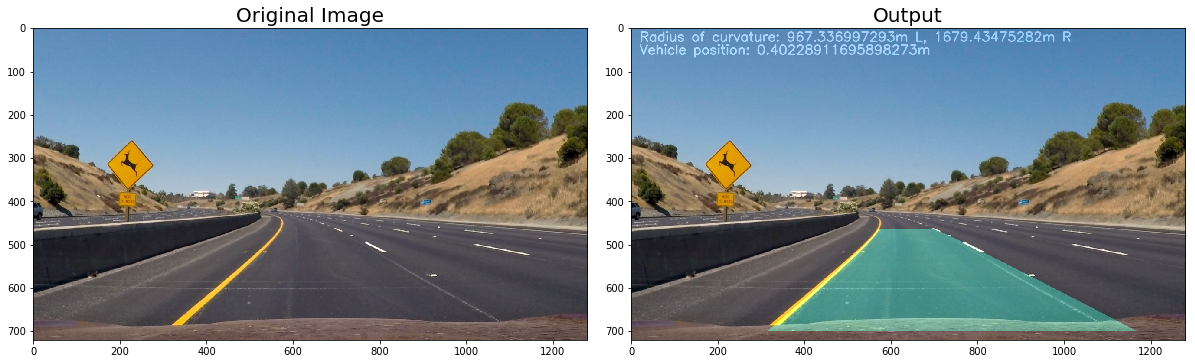

In [26]:
image = mpimg.imread('./test_images/test2.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(process_image(image))
ax2.set_title('Output', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
#plt.savefig('./outputs/final_processed.jpg')

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.video.VideoClip import VideoClip
from IPython.display import HTML

In [ ]:
challenge_output = 'challenge.mp4'

clip2 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))